In [53]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from statsmodels.tsa.arima_model import ARIMA


- --
# 시계열 데이터 예측
* 전통적인 방법으로 시계열 데이터를 예측할 때는 중요한 전제조건의 하나로 시계열 데이터가 정상성(stationary)을 가져야 한다. <br> 정상성을 가진다는 것은 데이터에 trend, cycle, seasonality 가 없는 데이터를 말한다. 일반적인 주가 데이터의 경우 정상성을 가지지 않는 경우가 많다.

# 정상성을 판단하는 법 - ADF, KPSS 등이 사용된다.

### ADF test  <br> H0 : 단위근이 존재한다. 즉 정상성에 의심이 간다. <br>H1 : 단위근이 존재하지 않는다. 즉, 정상성이 존재한다.
### KPSS test ~

- --
# 정상성을 가지는 데이터의 사례
* 저희가 생각해본 정상성을 가지는 데이터는 무작위로 추출한 데이터입니다.

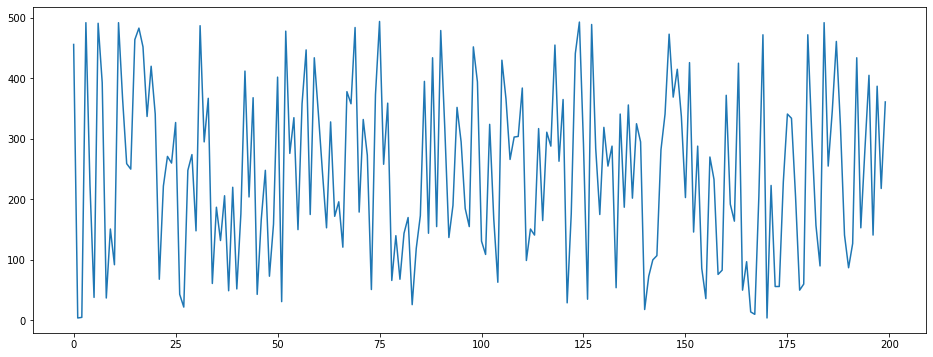

In [54]:
num = np.random.randint(500, size=200) # 무작위로 1 ~ 500 사이의 정수 중 200개를 추출해보았다.
result = adfuller(num)

plt.rcParams['figure.figsize'] = (16,6)
plt.plot(num) # line plot
plt.show()

In [55]:
print('ADF Statistics: %f' % result[0]) # p-value 0.05 를 넘으면 데이터의 정상성이 없다. 해결책이 차분이다.
print('p-value: %f'% result[1]) 
print('Critical values:')
for key,value in result[4].items(): # ADF의 p-value 가 0.0000 이기 떄문에 귀무가설을 기각해 데이터가 정상성을 가진다는것을 판단할 수 있다.
    print('\t%s %.3f' %(key,value))

ADF Statistics: -13.421434
p-value: 0.000000
Critical values:
	1% -3.464
	5% -2.876
	10% -2.575


- --
# DATA DOWNLOAD 

In [70]:
df_AAPL = yf.download('AAPL', start='2017-01-01', end='2021-08-31')

df_AAPL.reset_index(inplace=True)
df_AAPL['Date'] = pd.to_datetime(df_AAPL['Date'])

[*********************100%***********************]  1 of 1 completed


In [71]:
df_AAPL['Date']

0      2017-01-03
1      2017-01-04
2      2017-01-05
3      2017-01-06
4      2017-01-09
          ...    
1168   2021-08-24
1169   2021-08-25
1170   2021-08-26
1171   2021-08-27
1172   2021-08-30
Name: Date, Length: 1173, dtype: datetime64[ns]

<AxesSubplot:>

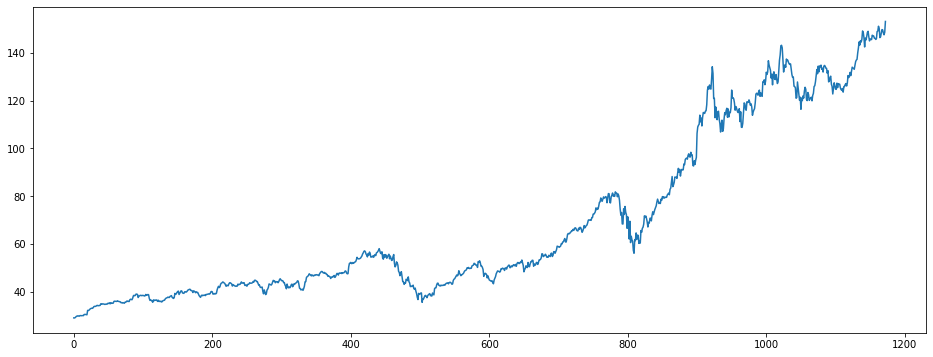

In [72]:
df_AAPL['Close'].plot()

- --
# Tesla의 종가(time series)의 정상성(stationary) 검정 1. Augmented Dicky Fuller test(ADF test)

##  ADF 간략한 설명
* ADF 는 정상성을 알아보기 위한 단위근 검정
### ADF 의 귀무가설과 대립가설 <br>귀무가설(null hypothesis, h0) 단위근이 존재한다. 즉 정상성에 의심이 간다. <br>대립가설(alternative hypothesis,h1)  단위근이 존재하지 않는다. 즉, 정상성이 존재한다.

In [73]:
result_ADF = adfuller(df_AAPL['Close'])

In [74]:
print('ADF Statistics: %f' % result_ADF[0]) # p-value 0.05 를 넘으면 데이터의 정상성이 없다. 해결책이 차분이다.
print('p-value: %f'% result_ADF[1]) 
print('Critical values:')
for key,value in result_ADF[4].items(): # ADF의 p-value 가 0.980243 이기 떄문에 귀무가설을 기각할 수 없다. 즉, 테슬라 종가는 정상성을 가지지 않는다.
    print('\t%s %.3f' %(key,value))


ADF Statistics: 0.699939
p-value: 0.989837
Critical values:
	1% -3.436
	5% -2.864
	10% -2.568


- --
# Tesla의 종가(time series)의 정상성(stationary) 검정 2. Kwiatkowski-Phillips-Schmidt-Shin test(kpss test)

##  kpss 간략한 설명
* kpss 도 정상성을 알아보기 위한 단위근 검정
### kpss 의 귀무가설과 대립가설 <br>귀무가설(null hypothesis, h0) 단위근이 존재하지 않는다. 즉 정상성이 있다. <br>대립가설(alternative hypothesis, h1)  단위근이 존재하지 않는다. 즉, 정상성에 의심이 간다.

In [75]:
result_kpss = kpss(df_AAPL['Close'])

In [76]:
print('ADF Statistics: %f' % result_kpss[0])
print('p-value: %f'% result_kpss[1]) 
print('Critical values:')
for key,value in result_kpss[3].items(): # kpss 의 p-value 가 0.01 이므로 귀무가설을 기각하기 때문에 테슬라 종가는 정상성을 가지지 않는다.
    print('\t%s %.3f' %(key,value))

ADF Statistics: 4.190529
p-value: 0.010000
Critical values:
	10% 0.347
	5% 0.463
	2.5% 0.574
	1% 0.739


- --
# AR, MA 를 판단하는 방법

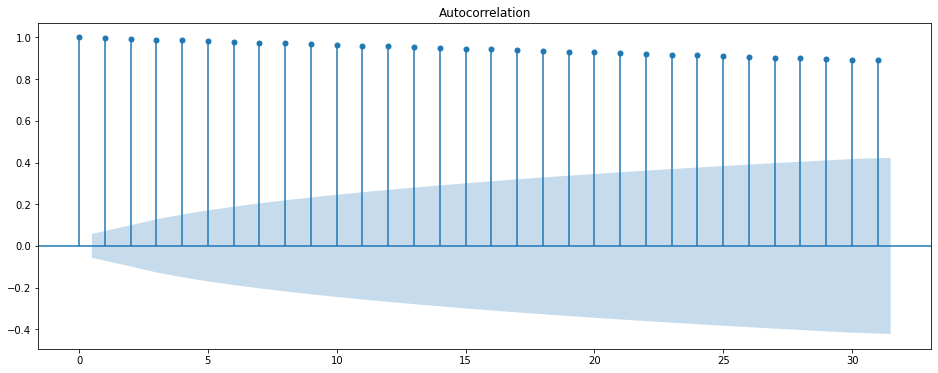

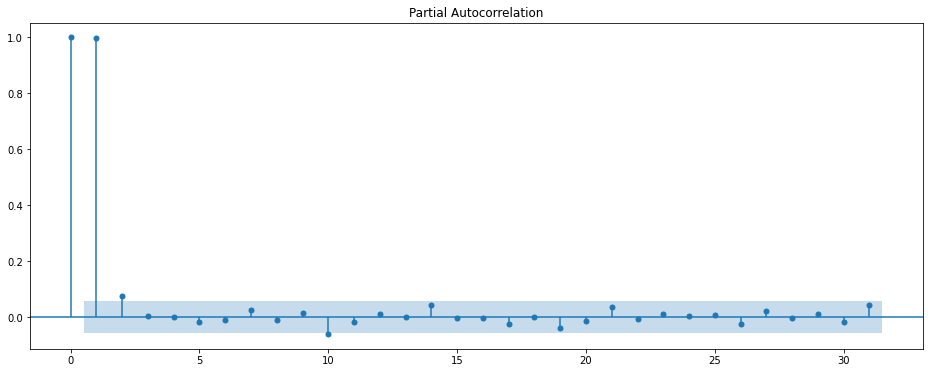

In [77]:
plot_acf(df_AAPL['Close'])
plot_pacf(df_AAPL['Close'])
plt.show()

- --
# ARIMA MODEL 해석 

### order(p,d,q) p = AR parameter, d = difference(차분) q = MA parameter


* see more [ARIMA Method User Guide](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html)

### 정상성을 가지지 않아 오류가 발생하는 사례

In [78]:
model = ARIMA(df_AAPL['Close'], order = (1,0,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

- --
# 차분을 통해 정상성을 가지지 않는 데이터가 정상성을 가지게 한다.

In [79]:
model = ARIMA(df_AAPL['Close'], order = (1,1,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2177.312
Method:                       css-mle   S.D. of innovations              1.551
Date:                Thu, 02 Sep 2021   AIC                           4362.623
Time:                        11:01:31   BIC                           4382.889
Sample:                             1   HQIC                          4370.266
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1056      0.042      2.540      0.011       0.024       0.187
ar.L1.D.Close    -0.3395      0.253     -1.343      0.179      -0.835       0.156
ma.L1.D.Close     0.2291      0.262     

P + Q < 2 P*Q =0

In [97]:
for i in range(1,4):
    for j in range(1,4):
        model = ARIMA(df_AAPL['Close'], order = (i,2,j))
        model_fit = model.fit(trend ='c', full_output= True, disp = True)
        print(model_fit.summary().tables[0])

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1171
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -2178.590
Method:                       css-mle   S.D. of innovations              1.550
Date:                Thu, 02 Sep 2021   AIC                           4365.180
Time:                        11:06:57   BIC                           4385.442
Sample:                             2   HQIC                          4372.822
                                                                              
                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1171
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -2178.334
Method:                       css-mle   S.D. of innovations              1.550
Date:                Thu, 02 Sep 2021   AIC         